In [1]:
#!pip install deeplake
#!pip install opencv-python

In [2]:
import json
import cv2
import deeplake as hub
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "segmentation": [poly],
                "xs": px,
                "ys": py,
                "label": "ballon",
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [ ]:
ann_dicts = get_balloon_dicts("balloon/train")

In [ ]:
def vis_annotation(img_dir):
    for i,ann in enumerate(ann_dicts):
        if i>5:
            break
        f_name=os.path.join(ann["file_name"])
        width=ann["width"]
        height=ann["height"]
        #print(f_name)
        img=cv2.imread(f_name)
        mask_img=np.zeros((height,width,3),dtype=np.uint8)
        if img is None:
            assert "Image is None"
        for an in ann["annotations"]:
            classlabel=an["label"]
            poly = [(x, y) for x, y in zip(an["xs"], an["ys"])]
            contours = np.array(poly)
            contours=np.int0(contours)
            cv2.drawContours(mask_img, [contours], 0, (150,150,0), -1)
            #cv2.fillPoly(mask_img, pts = [contours], color =(255,0,255))
        blend=cv2.addWeighted(img, 0.5, mask_img, 0.9, 0)
        combined = np.concatenate((img, blend), axis=1)
        plt.figure()
        plt.imshow(combined[...,::-1])

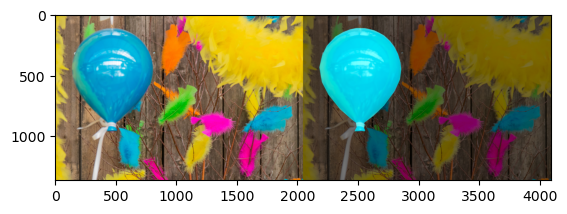

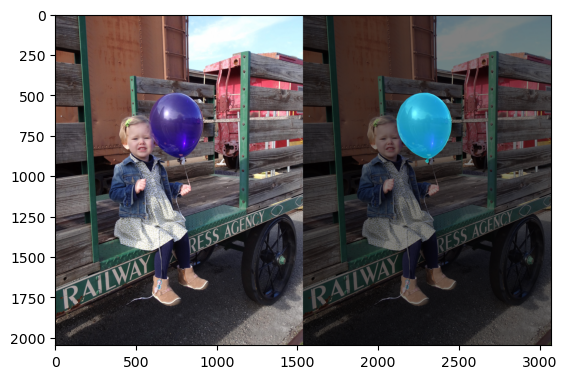

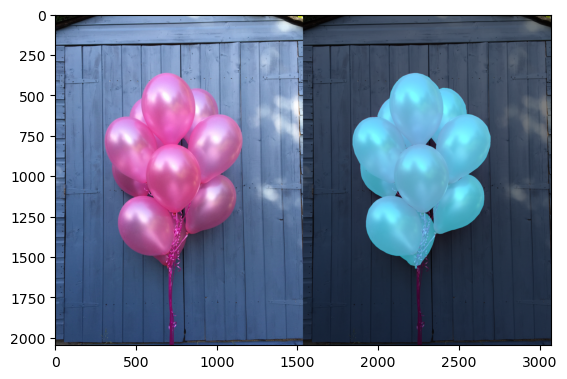

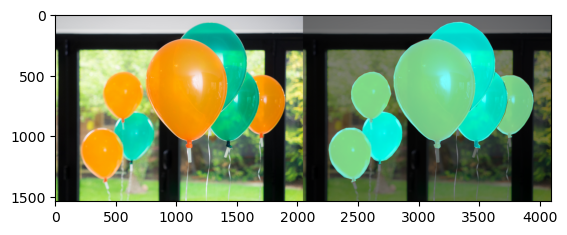

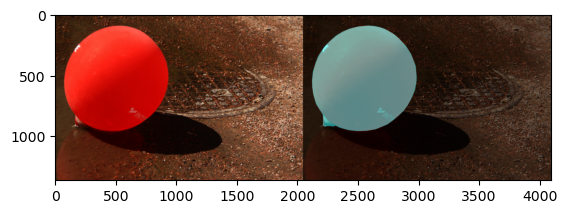

In [43]:
vis_annotation("balloon/train")

In [52]:
ds = hub.empty('hub://aismail2/Ballon_train',overwrite=True)

Your Deep Lake dataset has been successfully created!
The dataset is private so make sure you are logged in!




/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/aismail2/Ballon_train
hub://aismail2/Ballon_train loaded successfully.


In [53]:
class_names=["cucumber"]
class_map={"ballon":0}

In [54]:
def filter_data(bbox):
    minw=3
    minh=3
    if ((bbox[2]-bbox[0])<minw or (bbox[3]-bbox[1])<minh):
        return True
    else:
        return False

In [55]:
with ds:
    ds.create_tensor('images', htype='image',sample_compression = 'jpeg')
    ds.create_tensor('boxes', htype='bbox')
    ds.boxes.info.update(coords = {'type': 'pixel', 'mode': 'LTRB'})
    ds.create_tensor('labels', htype='class_label', class_names = class_names)
    ds.create_tensor('masks', htype = 'binary_mask', sample_compression = 'lz4')
    for val in ann_dicts:
        img_path=os.path.join(val["file_name"])
        height=val["height"]
        width=val["width"]
        assert os.path.exists(img_path)
        # Append data to tensors
        boxes=[]
        class_labels=[]
        masks=[]
        skip=False
        for ann in val["annotations"]:
            mask_img=np.zeros((height,width),dtype=np.uint8)
            skip=skip or filter_data(ann["bbox"])
            boxes.append(ann["bbox"])
            class_labels.append(class_map[ann["label"]])
            poly = [(x, y) for x, y in zip(ann["xs"], ann["ys"])]
            contours = np.array(poly)
            contours=np.int0(contours)
            cv2.fillPoly(mask_img, pts = [contours], color =255)
            masks.append(mask_img)  
        if (len(boxes))==0:
            print(f"Skipping no label!!")
            continue
        if skip:
            print(f"Skipping Image due to very small image")
            continue
        boxes=np.array(boxes)
        masks=np.array(masks)
        # make count last axis for masks require for vis by the tool
        masks=np.moveaxis(masks, 0, -1)
        class_labels=np.array(class_labels)
        ds.images.append(hub.read(img_path))
        ds.labels.append(class_labels.astype(np.uint32))
        ds.boxes.append(boxes.astype(np.float32))
        ds.masks.append(masks.astype(np.bool))

/tmp/ipykernel_2814/203470856.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ds.masks.append(masks.astype(np.bool))


In [56]:
first_commit_id = ds.commit('Added Ballon train dataset')

print('Dataset in commit {} has {} samples'.format(first_commit_id, len(ds)))

\

Dataset in commit firstdbf9474d461a19e9333c2fd19b46115348f has 61 samples


In [57]:
len(ds),len(ds.boxes),len(ds.labels)


(61, 61, 61)

In [58]:
ann_dicts = get_balloon_dicts("balloon/val")

In [59]:
ds = hub.empty('hub://aismail2/Ballon_val',overwrite=True)

Your Deep Lake dataset has been successfully created!
The dataset is private so make sure you are logged in!
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/aismail2/Ballon_val
hub://aismail2/Ballon_val loaded successfully.


In [60]:
with ds:
    ds.create_tensor('images', htype='image',sample_compression = 'jpeg')
    ds.create_tensor('boxes', htype='bbox')
    ds.boxes.info.update(coords = {'type': 'pixel', 'mode': 'LTRB'})
    ds.create_tensor('labels', htype='class_label', class_names = class_names)
    ds.create_tensor('masks', htype = 'binary_mask', sample_compression = 'lz4')
    for val in ann_dicts:
        img_path=os.path.join(val["file_name"])
        height=val["height"]
        width=val["width"]
        assert os.path.exists(img_path)
        # Append data to tensors
        boxes=[]
        class_labels=[]
        masks=[]
        skip=False
        for ann in val["annotations"]:
            mask_img=np.zeros((height,width),dtype=np.uint8)
            skip=skip or filter_data(ann["bbox"])
            boxes.append(ann["bbox"])
            class_labels.append(class_map[ann["label"]])
            poly = [(x, y) for x, y in zip(ann["xs"], ann["ys"])]
            contours = np.array(poly)
            contours=np.int0(contours)
            cv2.fillPoly(mask_img, pts = [contours], color =255)
            masks.append(mask_img)  
        if (len(boxes))==0:
            print(f"Skipping no label!!")
            continue
        if skip:
            print(f"Skipping Image due to very small image")
            continue
        boxes=np.array(boxes)
        masks=np.array(masks)
        # make count last axis for masks require for vis by the tool
        masks=np.moveaxis(masks, 0, -1)
        class_labels=np.array(class_labels)
        ds.images.append(hub.read(img_path))
        ds.labels.append(class_labels.astype(np.uint32))
        ds.boxes.append(boxes.astype(np.float32))
        ds.masks.append(masks.astype(np.bool))

/tmp/ipykernel_2814/203470856.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ds.masks.append(masks.astype(np.bool))


In [61]:
first_commit_id = ds.commit('Added Ballon val dataset')

print('Dataset in commit {} has {} samples'.format(first_commit_id, len(ds)))

|

Dataset in commit firstdbf9474d461a19e9333c2fd19b46115348f has 13 samples


In [62]:
len(ds),len(ds.boxes),len(ds.labels)

(13, 13, 13)